# Testing Optimizer with graph models in KGCNN

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
from kgcnn.data.datasets.ESOLDataset import ESOLDataset
dataset = ESOLDataset()
dataset.set_attributes()
dataset.map_list(method="set_edge_indices_reverse")

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name ESOL
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.ESOL:Found SDF C:\Users\patri\.kgcnn\datasets\ESOL\delaney-processed.sdf of pre-computed structures.
INFO:kgcnn.data.ESOL:Read molecules from mol-file.
INFO:kgcnn.data.ESOL: ... process molecules 0 from 1128
INFO:kgcnn.data.ESOL: ... process molecules 1000 from 1128
INFO:kgcnn.mol.encoder:OneHotEncoder Symbol found ['O', 'C', 'N', 'S', 'Cl', 'P', 'F', 'I', 'Br']
INFO:kgcnn.mol.encoder:OneHotEncoder Hybridization found [rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP, rdkit.Chem.rdchem.HybridizationType.SP2]
INFO:kgcnn.mol.encoder:OneHotEncoder TotalDegree found [2, 4, 1, 3]
INFO:kgcnn.mol.encoder:OneHotEncoder TotalNumHs found [1, 2, 0, 3, 4]
INFO:kgcnn.mol.encoder:OneHotEnc

In [3]:
from kgcnn.literature.DMPNN import make_model

In [4]:
model_config = {
    "name": "DMPNN",
    "inputs": [
        {"shape": [None, 41], "name": "node_attributes", "dtype": "float32", "ragged": True},
        {"shape": [None, 11], "name": "edge_attributes", "dtype": "float32", "ragged": True},
        {"shape": [None, 2], "name": "edge_indices", "dtype": "int64", "ragged": True},
        {"shape": [None, 1], "name": "edge_indices_reverse", "dtype": "int64", "ragged": True}
    ],
    "input_embedding": {"node": {"input_dim": 95, "output_dim": 64},
                        "edge": {"input_dim": 5, "output_dim": 64}},
    "pooling_args": {"pooling_method": "sum"},
    "edge_initialize": {"units": 128, "use_bias": True, "activation": "relu"},
    "edge_dense": {"units": 128, "use_bias": True, "activation": "linear"},
    "edge_activation": {"activation": "relu"},
    "node_dense": {"units": 128, "use_bias": True, "activation": "relu"},
    "verbose": 10, "depth": 5,
    "dropout": {"rate": 0.1},
    "output_embedding": "graph",
    "output_mlp": {
        "use_bias": [True, True, False], "units": [64, 32, 1],
        "activation": ["relu", "relu", "linear"]
    }
}
# Test making model
model = make_model(**model_config)

INFO:kgcnn.utils.models:Updated model kwargs:
INFO:kgcnn.utils.models:{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}, 'edge': {'input_dim': 5, 'output_dim': 64}, 'graph': {'input_dim': 100, 'output_dim': 64}}, 'pooling_args': {'pooling_method': 'sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activation': 'linear'}, 'edge_activation': {'activation': 'relu'}, 'node_dense': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'verbose': 10, 'depth': 5, 'dropout': {'rate': 0.1}, 'output_embedding': '

In [5]:
dataset.clean(model_config["inputs"])

INFO:kgcnn.data.ESOL:Property edge_attributes is an empty list for graph 934.
INFO:kgcnn.data.ESOL:Property edge_indices is an empty list for graph 934.
INFO:kgcnn.data.ESOL:Property edge_indices_reverse is an empty list for graph 934.


array([934])

In [6]:
labels = np.expand_dims(dataset.get("graph_labels"), axis=-1)
labels.shape

(1127, 1)

In [7]:
from copy import deepcopy
from sklearn.model_selection import train_test_split
from keras.backend import clear_session

In [8]:
from kgcnn.training.optimizer import Adan
from tensorflow.keras.optimizers import Adam, SGD, Adamax, Adadelta

In [9]:
train_index, test_index = train_test_split(np.arange(len(dataset)), test_size=0.25, random_state=42)
x_train, y_train = dataset[train_index].tensor(model_config["inputs"]), labels[train_index]
x_valid, y_valid = dataset[test_index].tensor(model_config["inputs"]), labels[test_index]

In [10]:
hist_opt = []
# Adan
opt_selection = [
    Adan(), Adam(), 
    SGD(), Adamax(), Adadelta()]

for opt in opt_selection:
    model = make_model(**model_config)
    print(opt)
    model.compile(
        loss="mean_absolute_error",
        optimizer=opt,
        metrics=["mean_absolute_error"],
    )
    hist_run = model.fit(
        x_train,
        y_train,
        validation_data=(x_valid, y_valid),
        shuffle=True,
        batch_size=32,
        epochs=300,
    )
    hist_opt.append(hist_run)

INFO:kgcnn.utils.models:Updated model kwargs:
INFO:kgcnn.utils.models:{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}, 'edge': {'input_dim': 5, 'output_dim': 64}, 'graph': {'input_dim': 100, 'output_dim': 64}}, 'pooling_args': {'pooling_method': 'sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activation': 'linear'}, 'edge_activation': {'activation': 'relu'}, 'node_dense': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'verbose': 10, 'depth': 5, 'dropout': {'rate': 0.1}, 'output_embedding': '

Epoch 1/300


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_11/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_11/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_11/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_9/gather_nodes_outgoing_11/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_9/gather_nodes_outgoing_11/Reshape:0", shape=(Non

27/27 [==============================] - 5s 56ms/step - loss: 2.9159 - mean_absolute_error: 2.9159 - val_loss: 1.1913 - val_mean_absolute_error: 1.1913
Epoch 2/300
27/27 [==============================] - 1s 28ms/step - loss: 1.1147 - mean_absolute_error: 1.1147 - val_loss: 0.9490 - val_mean_absolute_error: 0.9490
Epoch 3/300
27/27 [==============================] - 1s 27ms/step - loss: 0.9462 - mean_absolute_error: 0.9462 - val_loss: 0.8148 - val_mean_absolute_error: 0.8148
Epoch 4/300
27/27 [==============================] - 1s 26ms/step - loss: 0.8273 - mean_absolute_error: 0.8273 - val_loss: 0.7918 - val_mean_absolute_error: 0.7918
Epoch 5/300
27/27 [==============================] - 1s 27ms/step - loss: 0.7688 - mean_absolute_error: 0.7688 - val_loss: 0.7196 - val_mean_absolute_error: 0.7196
Epoch 6/300
27/27 [==============================] - 1s 27ms/step - loss: 0.7330 - mean_absolute_error: 0.7330 - val_loss: 0.6882 - val_mean_absolute_error: 0.6882
Epoch 7/300
27/27 [=========

Epoch 51/300
27/27 [==============================] - 1s 33ms/step - loss: 0.3245 - mean_absolute_error: 0.3245 - val_loss: 0.4292 - val_mean_absolute_error: 0.4292
Epoch 52/300
27/27 [==============================] - 1s 32ms/step - loss: 0.3270 - mean_absolute_error: 0.3270 - val_loss: 0.4610 - val_mean_absolute_error: 0.4610
Epoch 53/300
27/27 [==============================] - 1s 32ms/step - loss: 0.3237 - mean_absolute_error: 0.3237 - val_loss: 0.4338 - val_mean_absolute_error: 0.4338
Epoch 54/300
27/27 [==============================] - 1s 33ms/step - loss: 0.3215 - mean_absolute_error: 0.3215 - val_loss: 0.4419 - val_mean_absolute_error: 0.4419
Epoch 55/300
27/27 [==============================] - 1s 31ms/step - loss: 0.3140 - mean_absolute_error: 0.3140 - val_loss: 0.4398 - val_mean_absolute_error: 0.4398
Epoch 56/300
27/27 [==============================] - 1s 32ms/step - loss: 0.3287 - mean_absolute_error: 0.3287 - val_loss: 0.4625 - val_mean_absolute_error: 0.4625
Epoch 57/3

Epoch 101/300
27/27 [==============================] - 1s 32ms/step - loss: 0.2468 - mean_absolute_error: 0.2468 - val_loss: 0.4584 - val_mean_absolute_error: 0.4584
Epoch 102/300
27/27 [==============================] - 1s 32ms/step - loss: 0.2423 - mean_absolute_error: 0.2423 - val_loss: 0.4407 - val_mean_absolute_error: 0.4407
Epoch 103/300
27/27 [==============================] - 1s 33ms/step - loss: 0.2375 - mean_absolute_error: 0.2375 - val_loss: 0.4505 - val_mean_absolute_error: 0.4505
Epoch 104/300
27/27 [==============================] - 1s 32ms/step - loss: 0.2479 - mean_absolute_error: 0.2479 - val_loss: 0.4609 - val_mean_absolute_error: 0.4609
Epoch 105/300
27/27 [==============================] - 1s 32ms/step - loss: 0.2418 - mean_absolute_error: 0.2418 - val_loss: 0.4592 - val_mean_absolute_error: 0.4592
Epoch 106/300
27/27 [==============================] - 1s 33ms/step - loss: 0.2423 - mean_absolute_error: 0.2423 - val_loss: 0.4438 - val_mean_absolute_error: 0.4438
Epoc

27/27 [==============================] - 1s 33ms/step - loss: 0.1679 - mean_absolute_error: 0.1679 - val_loss: 0.4650 - val_mean_absolute_error: 0.4650
Epoch 200/300
27/27 [==============================] - 1s 32ms/step - loss: 0.1719 - mean_absolute_error: 0.1719 - val_loss: 0.4787 - val_mean_absolute_error: 0.4787
Epoch 201/300
27/27 [==============================] - 1s 32ms/step - loss: 0.1712 - mean_absolute_error: 0.1712 - val_loss: 0.4733 - val_mean_absolute_error: 0.4733
Epoch 202/300
27/27 [==============================] - 1s 32ms/step - loss: 0.1720 - mean_absolute_error: 0.1720 - val_loss: 0.4694 - val_mean_absolute_error: 0.4694
Epoch 203/300
27/27 [==============================] - 1s 32ms/step - loss: 0.1675 - mean_absolute_error: 0.1675 - val_loss: 0.4509 - val_mean_absolute_error: 0.4509
Epoch 204/300
27/27 [==============================] - 1s 32ms/step - loss: 0.1621 - mean_absolute_error: 0.1621 - val_loss: 0.4569 - val_mean_absolute_error: 0.4569
Epoch 205/300
27/2

27/27 [==============================] - 1s 33ms/step - loss: 0.1399 - mean_absolute_error: 0.1399 - val_loss: 0.4622 - val_mean_absolute_error: 0.4622
Epoch 298/300
27/27 [==============================] - 1s 32ms/step - loss: 0.1310 - mean_absolute_error: 0.1310 - val_loss: 0.4575 - val_mean_absolute_error: 0.4575
Epoch 299/300
27/27 [==============================] - 1s 33ms/step - loss: 0.1389 - mean_absolute_error: 0.1389 - val_loss: 0.4532 - val_mean_absolute_error: 0.4532
Epoch 300/300
27/27 [==============================] - 1s 32ms/step - loss: 0.1305 - mean_absolute_error: 0.1305 - val_loss: 0.4668 - val_mean_absolute_error: 0.4668


INFO:kgcnn.utils.models:Updated model kwargs:
INFO:kgcnn.utils.models:{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}, 'edge': {'input_dim': 5, 'output_dim': 64}, 'graph': {'input_dim': 100, 'output_dim': 64}}, 'pooling_args': {'pooling_method': 'sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activation': 'linear'}, 'edge_activation': {'activation': 'relu'}, 'node_dense': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'verbose': 10, 'depth': 5, 'dropout': {'rate': 0.1}, 'output_embedding': '

Epoch 1/300


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_17/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_17/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_17/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_14/gather_nodes_outgoing_17/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_14/gather_nodes_outgoing_17/Reshape:0", shape=(N

27/27 [==============================] - 4s 49ms/step - loss: 1.8788 - mean_absolute_error: 1.8788 - val_loss: 1.1668 - val_mean_absolute_error: 1.1668
Epoch 2/300
27/27 [==============================] - 1s 21ms/step - loss: 1.1071 - mean_absolute_error: 1.1071 - val_loss: 1.0220 - val_mean_absolute_error: 1.0220
Epoch 3/300
27/27 [==============================] - 1s 21ms/step - loss: 0.9245 - mean_absolute_error: 0.9245 - val_loss: 0.9399 - val_mean_absolute_error: 0.9399
Epoch 4/300
27/27 [==============================] - 1s 21ms/step - loss: 0.8479 - mean_absolute_error: 0.8479 - val_loss: 0.7746 - val_mean_absolute_error: 0.7746
Epoch 5/300
27/27 [==============================] - 1s 21ms/step - loss: 0.8107 - mean_absolute_error: 0.8107 - val_loss: 0.7820 - val_mean_absolute_error: 0.7820
Epoch 6/300
27/27 [==============================] - 1s 21ms/step - loss: 0.7941 - mean_absolute_error: 0.7941 - val_loss: 0.9759 - val_mean_absolute_error: 0.9759
Epoch 7/300
27/27 [=========

Epoch 51/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3468 - mean_absolute_error: 0.3468 - val_loss: 0.4554 - val_mean_absolute_error: 0.4554
Epoch 52/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3179 - mean_absolute_error: 0.3179 - val_loss: 0.4762 - val_mean_absolute_error: 0.4762
Epoch 53/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3126 - mean_absolute_error: 0.3126 - val_loss: 0.4425 - val_mean_absolute_error: 0.4425
Epoch 54/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3267 - mean_absolute_error: 0.3267 - val_loss: 0.4632 - val_mean_absolute_error: 0.4632
Epoch 55/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2993 - mean_absolute_error: 0.2993 - val_loss: 0.5014 - val_mean_absolute_error: 0.5014
Epoch 56/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3239 - mean_absolute_error: 0.3239 - val_loss: 0.4592 - val_mean_absolute_error: 0.4592
Epoch 57/3

Epoch 101/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2588 - mean_absolute_error: 0.2588 - val_loss: 0.4491 - val_mean_absolute_error: 0.4491
Epoch 102/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2418 - mean_absolute_error: 0.2418 - val_loss: 0.4843 - val_mean_absolute_error: 0.4843
Epoch 103/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2574 - mean_absolute_error: 0.2574 - val_loss: 0.4710 - val_mean_absolute_error: 0.4710
Epoch 104/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2366 - mean_absolute_error: 0.2366 - val_loss: 0.4572 - val_mean_absolute_error: 0.4572
Epoch 105/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2398 - mean_absolute_error: 0.2398 - val_loss: 0.5288 - val_mean_absolute_error: 0.5288
Epoch 106/300
27/27 [==============================] - 1s 20ms/step - loss: 0.2528 - mean_absolute_error: 0.2528 - val_loss: 0.4571 - val_mean_absolute_error: 0.4571
Epoc

27/27 [==============================] - 1s 21ms/step - loss: 0.1718 - mean_absolute_error: 0.1718 - val_loss: 0.4644 - val_mean_absolute_error: 0.4644
Epoch 200/300
27/27 [==============================] - 1s 21ms/step - loss: 0.1697 - mean_absolute_error: 0.1697 - val_loss: 0.4710 - val_mean_absolute_error: 0.4710
Epoch 201/300
27/27 [==============================] - 1s 21ms/step - loss: 0.1811 - mean_absolute_error: 0.1811 - val_loss: 0.4762 - val_mean_absolute_error: 0.4762
Epoch 202/300
27/27 [==============================] - 1s 20ms/step - loss: 0.1888 - mean_absolute_error: 0.1888 - val_loss: 0.4371 - val_mean_absolute_error: 0.4371
Epoch 203/300
27/27 [==============================] - 1s 21ms/step - loss: 0.1815 - mean_absolute_error: 0.1815 - val_loss: 0.4855 - val_mean_absolute_error: 0.4855
Epoch 204/300
27/27 [==============================] - 1s 21ms/step - loss: 0.1940 - mean_absolute_error: 0.1940 - val_loss: 0.4701 - val_mean_absolute_error: 0.4701
Epoch 205/300
27/2

27/27 [==============================] - 1s 21ms/step - loss: 0.1439 - mean_absolute_error: 0.1439 - val_loss: 0.4678 - val_mean_absolute_error: 0.4678
Epoch 298/300
27/27 [==============================] - 1s 20ms/step - loss: 0.1408 - mean_absolute_error: 0.1408 - val_loss: 0.4492 - val_mean_absolute_error: 0.4492
Epoch 299/300
27/27 [==============================] - 1s 21ms/step - loss: 0.1505 - mean_absolute_error: 0.1505 - val_loss: 0.4538 - val_mean_absolute_error: 0.4538
Epoch 300/300
27/27 [==============================] - 1s 21ms/step - loss: 0.1440 - mean_absolute_error: 0.1440 - val_loss: 0.4518 - val_mean_absolute_error: 0.4518


INFO:kgcnn.utils.models:Updated model kwargs:
INFO:kgcnn.utils.models:{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}, 'edge': {'input_dim': 5, 'output_dim': 64}, 'graph': {'input_dim': 100, 'output_dim': 64}}, 'pooling_args': {'pooling_method': 'sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activation': 'linear'}, 'edge_activation': {'activation': 'relu'}, 'node_dense': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'verbose': 10, 'depth': 5, 'dropout': {'rate': 0.1}, 'output_embedding': '

Epoch 1/300


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_23/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_23/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_23/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_19/gather_nodes_outgoing_23/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_19/gather_nodes_outgoing_23/Reshape:0", shape=(N

27/27 [==============================] - 3s 49ms/step - loss: 3.7014 - mean_absolute_error: 3.7014 - val_loss: 1.1775 - val_mean_absolute_error: 1.1775
Epoch 2/300
27/27 [==============================] - 1s 21ms/step - loss: 1.2368 - mean_absolute_error: 1.2368 - val_loss: 1.2783 - val_mean_absolute_error: 1.2783
Epoch 3/300
27/27 [==============================] - 1s 21ms/step - loss: 1.1508 - mean_absolute_error: 1.1508 - val_loss: 1.1506 - val_mean_absolute_error: 1.1506
Epoch 4/300
27/27 [==============================] - 1s 21ms/step - loss: 1.1099 - mean_absolute_error: 1.1099 - val_loss: 0.8819 - val_mean_absolute_error: 0.8819
Epoch 5/300
27/27 [==============================] - 1s 21ms/step - loss: 1.0198 - mean_absolute_error: 1.0198 - val_loss: 0.8588 - val_mean_absolute_error: 0.8588
Epoch 6/300
27/27 [==============================] - 1s 21ms/step - loss: 0.9257 - mean_absolute_error: 0.9257 - val_loss: 1.0262 - val_mean_absolute_error: 1.0262
Epoch 7/300
27/27 [=========

Epoch 51/300
27/27 [==============================] - 1s 21ms/step - loss: 0.5416 - mean_absolute_error: 0.5416 - val_loss: 0.5114 - val_mean_absolute_error: 0.5114
Epoch 52/300
27/27 [==============================] - 1s 21ms/step - loss: 0.5233 - mean_absolute_error: 0.5233 - val_loss: 0.6833 - val_mean_absolute_error: 0.6833
Epoch 53/300
27/27 [==============================] - 1s 21ms/step - loss: 0.5700 - mean_absolute_error: 0.5700 - val_loss: 0.8206 - val_mean_absolute_error: 0.8206
Epoch 54/300
27/27 [==============================] - 1s 21ms/step - loss: 0.5913 - mean_absolute_error: 0.5913 - val_loss: 0.7156 - val_mean_absolute_error: 0.7156
Epoch 55/300
27/27 [==============================] - 1s 21ms/step - loss: 0.4946 - mean_absolute_error: 0.4946 - val_loss: 0.5920 - val_mean_absolute_error: 0.5920
Epoch 56/300
27/27 [==============================] - 1s 21ms/step - loss: 0.5409 - mean_absolute_error: 0.5409 - val_loss: 0.5735 - val_mean_absolute_error: 0.5735
Epoch 57/3

Epoch 101/300
27/27 [==============================] - 1s 21ms/step - loss: 0.4652 - mean_absolute_error: 0.4652 - val_loss: 0.6379 - val_mean_absolute_error: 0.6379
Epoch 102/300
27/27 [==============================] - 1s 20ms/step - loss: 0.4229 - mean_absolute_error: 0.4229 - val_loss: 0.6012 - val_mean_absolute_error: 0.6012
Epoch 103/300
27/27 [==============================] - 1s 21ms/step - loss: 0.4154 - mean_absolute_error: 0.4154 - val_loss: 0.5223 - val_mean_absolute_error: 0.5223
Epoch 104/300
27/27 [==============================] - 1s 20ms/step - loss: 0.4623 - mean_absolute_error: 0.4623 - val_loss: 0.5804 - val_mean_absolute_error: 0.5804
Epoch 105/300
27/27 [==============================] - 1s 21ms/step - loss: 0.4405 - mean_absolute_error: 0.4405 - val_loss: 0.5695 - val_mean_absolute_error: 0.5695
Epoch 106/300
27/27 [==============================] - 1s 20ms/step - loss: 0.4335 - mean_absolute_error: 0.4335 - val_loss: 0.5555 - val_mean_absolute_error: 0.5555
Epoc

27/27 [==============================] - 1s 21ms/step - loss: 0.3806 - mean_absolute_error: 0.3806 - val_loss: 0.6014 - val_mean_absolute_error: 0.6014
Epoch 200/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3278 - mean_absolute_error: 0.3278 - val_loss: 0.8022 - val_mean_absolute_error: 0.8022
Epoch 201/300
27/27 [==============================] - 1s 20ms/step - loss: 0.3892 - mean_absolute_error: 0.3892 - val_loss: 0.4952 - val_mean_absolute_error: 0.4952
Epoch 202/300
27/27 [==============================] - 1s 20ms/step - loss: 0.3624 - mean_absolute_error: 0.3624 - val_loss: 0.5955 - val_mean_absolute_error: 0.5955
Epoch 203/300
27/27 [==============================] - 1s 20ms/step - loss: 0.3606 - mean_absolute_error: 0.3606 - val_loss: 0.5440 - val_mean_absolute_error: 0.5440
Epoch 204/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3748 - mean_absolute_error: 0.3748 - val_loss: 0.7378 - val_mean_absolute_error: 0.7378
Epoch 205/300
27/2

27/27 [==============================] - 1s 19ms/step - loss: 0.3132 - mean_absolute_error: 0.3132 - val_loss: 0.5061 - val_mean_absolute_error: 0.5061
Epoch 298/300
27/27 [==============================] - 1s 19ms/step - loss: 0.3169 - mean_absolute_error: 0.3169 - val_loss: 0.6024 - val_mean_absolute_error: 0.6024
Epoch 299/300
27/27 [==============================] - 1s 19ms/step - loss: 0.3484 - mean_absolute_error: 0.3484 - val_loss: 0.4931 - val_mean_absolute_error: 0.4931
Epoch 300/300
27/27 [==============================] - 1s 19ms/step - loss: 0.3167 - mean_absolute_error: 0.3167 - val_loss: 0.5726 - val_mean_absolute_error: 0.5726


INFO:kgcnn.utils.models:Updated model kwargs:
INFO:kgcnn.utils.models:{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}, 'edge': {'input_dim': 5, 'output_dim': 64}, 'graph': {'input_dim': 100, 'output_dim': 64}}, 'pooling_args': {'pooling_method': 'sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activation': 'linear'}, 'edge_activation': {'activation': 'relu'}, 'node_dense': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'verbose': 10, 'depth': 5, 'dropout': {'rate': 0.1}, 'output_embedding': '

Epoch 1/300


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_29/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_29/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_29/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_24/gather_nodes_outgoing_29/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_24/gather_nodes_outgoing_29/Reshape:0", shape=(N

27/27 [==============================] - 3s 47ms/step - loss: 3.5690 - mean_absolute_error: 3.5690 - val_loss: 1.2596 - val_mean_absolute_error: 1.2596
Epoch 2/300
27/27 [==============================] - 1s 20ms/step - loss: 1.3282 - mean_absolute_error: 1.3282 - val_loss: 1.0497 - val_mean_absolute_error: 1.0497
Epoch 3/300
27/27 [==============================] - 1s 19ms/step - loss: 1.0693 - mean_absolute_error: 1.0693 - val_loss: 0.8601 - val_mean_absolute_error: 0.8601
Epoch 4/300
27/27 [==============================] - 1s 19ms/step - loss: 0.9956 - mean_absolute_error: 0.9956 - val_loss: 0.9068 - val_mean_absolute_error: 0.9068
Epoch 5/300
27/27 [==============================] - 1s 19ms/step - loss: 0.9365 - mean_absolute_error: 0.9365 - val_loss: 0.8372 - val_mean_absolute_error: 0.8372
Epoch 6/300
27/27 [==============================] - 1s 19ms/step - loss: 0.9398 - mean_absolute_error: 0.9398 - val_loss: 0.8056 - val_mean_absolute_error: 0.8056
Epoch 7/300
27/27 [=========

Epoch 51/300
27/27 [==============================] - 1s 21ms/step - loss: 0.4789 - mean_absolute_error: 0.4789 - val_loss: 0.5111 - val_mean_absolute_error: 0.5111
Epoch 52/300
27/27 [==============================] - 1s 21ms/step - loss: 0.4699 - mean_absolute_error: 0.4699 - val_loss: 0.4971 - val_mean_absolute_error: 0.4971
Epoch 53/300
27/27 [==============================] - 1s 21ms/step - loss: 0.4685 - mean_absolute_error: 0.4685 - val_loss: 0.5414 - val_mean_absolute_error: 0.5414
Epoch 54/300
27/27 [==============================] - 1s 21ms/step - loss: 0.4492 - mean_absolute_error: 0.4492 - val_loss: 0.5151 - val_mean_absolute_error: 0.5151
Epoch 55/300
27/27 [==============================] - 1s 21ms/step - loss: 0.4742 - mean_absolute_error: 0.4742 - val_loss: 0.5544 - val_mean_absolute_error: 0.5544
Epoch 56/300
27/27 [==============================] - 1s 21ms/step - loss: 0.4825 - mean_absolute_error: 0.4825 - val_loss: 0.5225 - val_mean_absolute_error: 0.5225
Epoch 57/3

Epoch 101/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3641 - mean_absolute_error: 0.3641 - val_loss: 0.4771 - val_mean_absolute_error: 0.4771
Epoch 102/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3516 - mean_absolute_error: 0.3516 - val_loss: 0.4770 - val_mean_absolute_error: 0.4770
Epoch 103/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3806 - mean_absolute_error: 0.3806 - val_loss: 0.5060 - val_mean_absolute_error: 0.5060
Epoch 104/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3612 - mean_absolute_error: 0.3612 - val_loss: 0.4453 - val_mean_absolute_error: 0.4453
Epoch 105/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3691 - mean_absolute_error: 0.3691 - val_loss: 0.4441 - val_mean_absolute_error: 0.4441
Epoch 106/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3145 - mean_absolute_error: 0.3145 - val_loss: 0.5094 - val_mean_absolute_error: 0.5094
Epoc

27/27 [==============================] - 1s 21ms/step - loss: 0.2470 - mean_absolute_error: 0.2470 - val_loss: 0.4594 - val_mean_absolute_error: 0.4594
Epoch 200/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2680 - mean_absolute_error: 0.2680 - val_loss: 0.4960 - val_mean_absolute_error: 0.4960
Epoch 201/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2307 - mean_absolute_error: 0.2307 - val_loss: 0.4284 - val_mean_absolute_error: 0.4284
Epoch 202/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2306 - mean_absolute_error: 0.2306 - val_loss: 0.4748 - val_mean_absolute_error: 0.4748
Epoch 203/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2393 - mean_absolute_error: 0.2393 - val_loss: 0.4804 - val_mean_absolute_error: 0.4804
Epoch 204/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2450 - mean_absolute_error: 0.2450 - val_loss: 0.4845 - val_mean_absolute_error: 0.4845
Epoch 205/300
27/2

27/27 [==============================] - 1s 21ms/step - loss: 0.2003 - mean_absolute_error: 0.2003 - val_loss: 0.4785 - val_mean_absolute_error: 0.4785
Epoch 298/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2098 - mean_absolute_error: 0.2098 - val_loss: 0.4363 - val_mean_absolute_error: 0.4363
Epoch 299/300
27/27 [==============================] - 1s 21ms/step - loss: 0.2024 - mean_absolute_error: 0.2024 - val_loss: 0.4552 - val_mean_absolute_error: 0.4552
Epoch 300/300
27/27 [==============================] - 1s 21ms/step - loss: 0.1798 - mean_absolute_error: 0.1798 - val_loss: 0.4478 - val_mean_absolute_error: 0.4478


INFO:kgcnn.utils.models:Updated model kwargs:
INFO:kgcnn.utils.models:{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}, 'edge': {'input_dim': 5, 'output_dim': 64}, 'graph': {'input_dim': 100, 'output_dim': 64}}, 'pooling_args': {'pooling_method': 'sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activation': 'linear'}, 'edge_activation': {'activation': 'relu'}, 'node_dense': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'verbose': 10, 'depth': 5, 'dropout': {'rate': 0.1}, 'output_embedding': '

Epoch 1/300


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_35/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_35/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_35/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_29/gather_nodes_outgoing_35/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_29/gather_nodes_outgoing_35/Reshape:0", shape=(N

27/27 [==============================] - 3s 48ms/step - loss: 3.6480 - mean_absolute_error: 3.6480 - val_loss: 3.0386 - val_mean_absolute_error: 3.0386
Epoch 2/300
27/27 [==============================] - 1s 21ms/step - loss: 3.2540 - mean_absolute_error: 3.2540 - val_loss: 2.5974 - val_mean_absolute_error: 2.5974
Epoch 3/300
27/27 [==============================] - 1s 21ms/step - loss: 2.8877 - mean_absolute_error: 2.8877 - val_loss: 2.1994 - val_mean_absolute_error: 2.1994
Epoch 4/300
27/27 [==============================] - 1s 21ms/step - loss: 2.5258 - mean_absolute_error: 2.5258 - val_loss: 1.9123 - val_mean_absolute_error: 1.9123
Epoch 5/300
27/27 [==============================] - 1s 21ms/step - loss: 2.3100 - mean_absolute_error: 2.3100 - val_loss: 1.7502 - val_mean_absolute_error: 1.7502
Epoch 6/300
27/27 [==============================] - 1s 21ms/step - loss: 2.0981 - mean_absolute_error: 2.0981 - val_loss: 1.6935 - val_mean_absolute_error: 1.6935
Epoch 7/300
27/27 [=========

Epoch 51/300
27/27 [==============================] - 1s 21ms/step - loss: 1.4127 - mean_absolute_error: 1.4127 - val_loss: 1.3245 - val_mean_absolute_error: 1.3245
Epoch 52/300
27/27 [==============================] - 1s 20ms/step - loss: 1.3995 - mean_absolute_error: 1.3995 - val_loss: 1.2811 - val_mean_absolute_error: 1.2811
Epoch 53/300
27/27 [==============================] - 1s 21ms/step - loss: 1.4709 - mean_absolute_error: 1.4709 - val_loss: 1.3389 - val_mean_absolute_error: 1.3389
Epoch 54/300
27/27 [==============================] - 1s 21ms/step - loss: 1.4360 - mean_absolute_error: 1.4360 - val_loss: 1.3034 - val_mean_absolute_error: 1.3034
Epoch 55/300
27/27 [==============================] - 1s 21ms/step - loss: 1.4186 - mean_absolute_error: 1.4186 - val_loss: 1.3251 - val_mean_absolute_error: 1.3251
Epoch 56/300
27/27 [==============================] - 1s 20ms/step - loss: 1.3859 - mean_absolute_error: 1.3859 - val_loss: 1.2961 - val_mean_absolute_error: 1.2961
Epoch 57/3

Epoch 101/300
27/27 [==============================] - 1s 21ms/step - loss: 1.3364 - mean_absolute_error: 1.3364 - val_loss: 1.2918 - val_mean_absolute_error: 1.2918
Epoch 102/300
27/27 [==============================] - 1s 21ms/step - loss: 1.2879 - mean_absolute_error: 1.2879 - val_loss: 1.3042 - val_mean_absolute_error: 1.3042
Epoch 103/300
27/27 [==============================] - 1s 20ms/step - loss: 1.2554 - mean_absolute_error: 1.2554 - val_loss: 1.2625 - val_mean_absolute_error: 1.2625
Epoch 104/300
27/27 [==============================] - 1s 20ms/step - loss: 1.2426 - mean_absolute_error: 1.2426 - val_loss: 1.2857 - val_mean_absolute_error: 1.2857
Epoch 105/300
27/27 [==============================] - 1s 21ms/step - loss: 1.2476 - mean_absolute_error: 1.2476 - val_loss: 1.2773 - val_mean_absolute_error: 1.2773
Epoch 106/300
27/27 [==============================] - 1s 21ms/step - loss: 1.2369 - mean_absolute_error: 1.2369 - val_loss: 1.2673 - val_mean_absolute_error: 1.2673
Epoc

27/27 [==============================] - 1s 21ms/step - loss: 1.1710 - mean_absolute_error: 1.1710 - val_loss: 1.2423 - val_mean_absolute_error: 1.2423
Epoch 200/300
27/27 [==============================] - 1s 21ms/step - loss: 1.1753 - mean_absolute_error: 1.1753 - val_loss: 1.2464 - val_mean_absolute_error: 1.2464
Epoch 201/300
27/27 [==============================] - 1s 21ms/step - loss: 1.1352 - mean_absolute_error: 1.1352 - val_loss: 1.2431 - val_mean_absolute_error: 1.2431
Epoch 202/300
27/27 [==============================] - 1s 21ms/step - loss: 1.1639 - mean_absolute_error: 1.1639 - val_loss: 1.2389 - val_mean_absolute_error: 1.2389
Epoch 203/300
27/27 [==============================] - 1s 21ms/step - loss: 1.1196 - mean_absolute_error: 1.1196 - val_loss: 1.2229 - val_mean_absolute_error: 1.2229
Epoch 204/300
27/27 [==============================] - 1s 21ms/step - loss: 1.1430 - mean_absolute_error: 1.1430 - val_loss: 1.2302 - val_mean_absolute_error: 1.2302
Epoch 205/300
27/2

27/27 [==============================] - 1s 21ms/step - loss: 1.0534 - mean_absolute_error: 1.0534 - val_loss: 1.1551 - val_mean_absolute_error: 1.1551
Epoch 298/300
27/27 [==============================] - 1s 21ms/step - loss: 1.0567 - mean_absolute_error: 1.0567 - val_loss: 1.1096 - val_mean_absolute_error: 1.1096
Epoch 299/300
27/27 [==============================] - 1s 21ms/step - loss: 1.0639 - mean_absolute_error: 1.0639 - val_loss: 1.1221 - val_mean_absolute_error: 1.1221
Epoch 300/300
27/27 [==============================] - 1s 20ms/step - loss: 1.0676 - mean_absolute_error: 1.0676 - val_loss: 1.1126 - val_mean_absolute_error: 1.1126


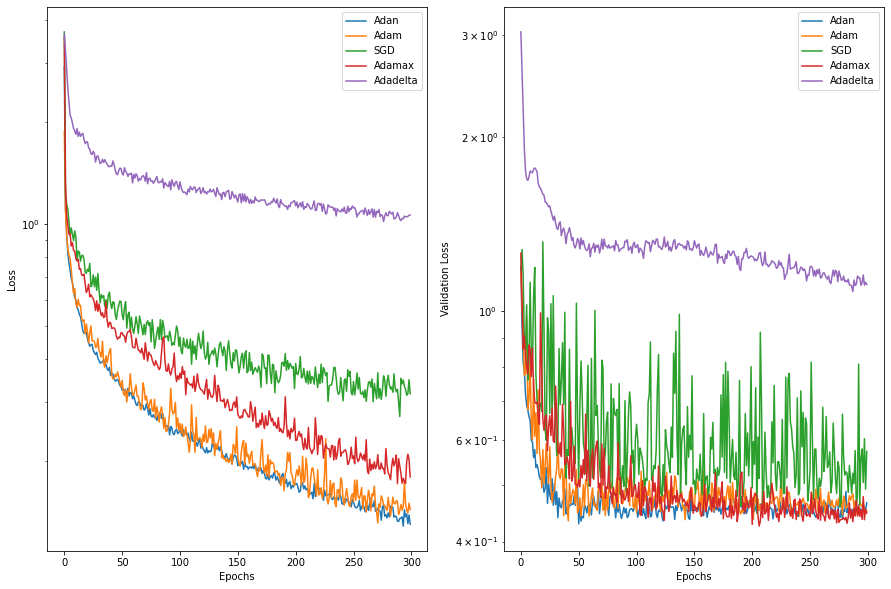

In [11]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15,10))
for hist_run, opt in zip(hist_opt, opt_selection):
    axs[0].plot(hist_run.history["loss"], label=opt.get_config()["name"])
    axs[0].set_ylabel("Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_yscale("log")
    axs[0].legend()
for hist_run, opt in zip(hist_opt, opt_selection):
    axs[1].plot(hist_run.history["val_loss"], label=opt.get_config()["name"])
    axs[1].set_ylabel("Validation Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].set_yscale("log")
    axs[1].legend()

In [13]:
confs = [x.get_config() for x in opt_selection]
confs;